# Quantum Variational Circuits (QVCs) and Quantum Neural Networks (QNNs)

Presented by:

- Juan Esteban Huertas Serrano
- Cesar Arthuro Lemos Silva
- Omar David Toledo Leguizamón

In [1]:
!pip install -q qiskit
!pip install -q qiskit_aer
!pip install -q qiskit-machine-learning --upgrade
!pip install -q qiskit_algorithms
!pip install -q pylatexenc

In [2]:
# Qiskit elements
from qiskit.circuit.library import ZZFeatureMap, TwoLocal, z_feature_map
from qiskit.circuit import Parameter, Gate, ParameterVector
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit.quantum_info import Operator, SparsePauliOp
from qiskit.primitives import Estimator
from qiskit import QuantumCircuit
# Classical ML utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.datasets import make_blobs
from sklearn.metrics import classification_report
# Visualization utilities
import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import keras
import warnings

# Filter warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
# Cached for adhoc reproducibility
cached = None

2025-11-30 12:11:09.546685: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


We are now in the world of Quantum Machine Learning. Here we will be encouraged to solve a classification task. We will compare the behaviour of a Quantum NN and a Classical NN. Our approach, will be doing 3 different scenarios with structured and unstructured data

## Data gathering

The different scenarios will be described by the datasets. Each of them will have 100 samples and some particularities to take into account.



### Classical Scenario

The first one, will be done using the toy datasets that are available in sci-kit learn. In order to see the evaluate the performance using

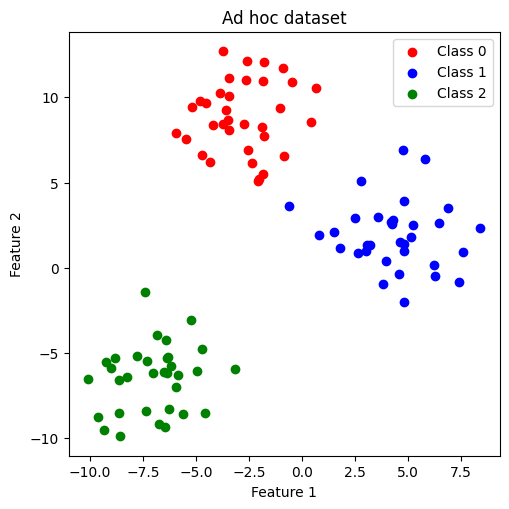

In [3]:
def gen_toy(n_features=2, n_classes=3) -> tuple:
    X, y = make_blobs(
        n_samples=100,
        n_features=n_features,
        centers=n_classes,
        random_state=42,
        cluster_std=2,
    )
    return train_test_split(X, y, test_size=0.3, random_state=42)

X_train, X_test, y_train, y_test = gen_toy()
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

plt.figure(figsize=(5, 5))
for i,c in enumerate(["r","b","g"]):
  plt.scatter(X[y==i, 0], X[y==i, 1], color = c, label = f"Class {i}")

plt.legend()
plt.title("Ad hoc dataset")
plt.tight_layout()
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


### Quantum Scenario

The following task will be done with a simple dataset designed to work good using quantum machine learning algorithms. The `ad_hoc` dataset, which is designed for be solved using a ZZ feature mapping.

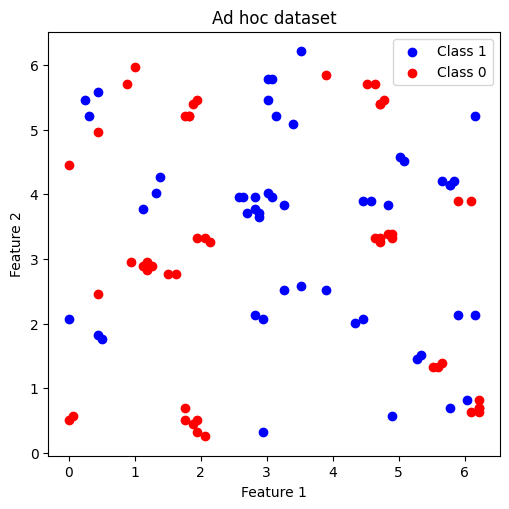

In [4]:
def gen_ad_hoc(n_features=2) -> tuple:
  global cached
  if cached is None:
      cached = ad_hoc_data(
        training_size = 35,
        test_size = 15,
        one_hot=False,
        n = n_features,
        gap = 0.6)
  return tuple(np.copy(arr) for arr in cached)

X_train, y_train, X_test, y_test = gen_ad_hoc()
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)
mask = y.astype(bool)
plt.figure(figsize=(5, 5))
plt.scatter(X[mask, 0], X[mask, 1], color = "b", label = "Class 1")
plt.scatter(X[~mask, 0], X[~mask, 1], color = "r", label = "Class 0")
plt.legend()
plt.title("Ad hoc dataset")
plt.tight_layout()
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


### Qiskit Example Scenario

The last one, will be defined using the image-oriented approach used in [Qiskit documentation](https://quantum.cloud.ibm.com/learning/en/courses/quantum-machine-learning/qvc-qnn)

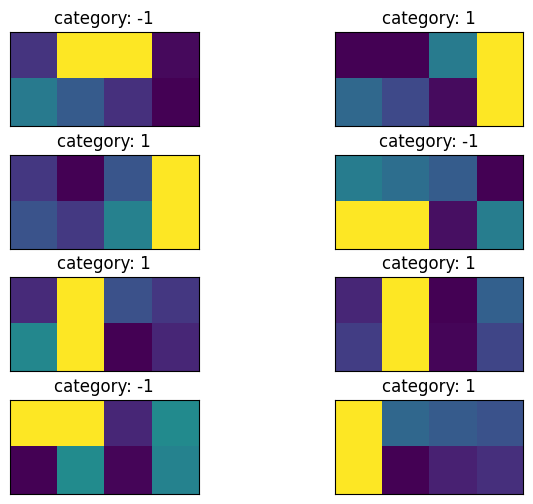

In [5]:
size = 8
vert_size = 2
line_size = 2

def generate_dataset(num_images=100):
    images = []
    labels = []
    hor_array = np.zeros((size - (line_size - 1) * vert_size, size))
    ver_array = np.zeros((round(size / vert_size) * (vert_size - line_size + 1), size))

    j = 0
    for i in range(0, size - 1):
        if i % (size / vert_size) <= (size / vert_size) - line_size:
            for p in range(0, line_size):
                hor_array[j][i + p] = np.pi / 2
            j += 1

    # Make two adjacent entries pi/2, then move down to the next row. Careful to avoid the "pixels" at size/vert_size - linesize, because we want to fold this list into a grid.

    j = 0
    for i in range(0, round(size / vert_size) * (vert_size - line_size + 1)):
        for p in range(0, line_size):
            ver_array[j][i + p * round(size / vert_size)] = np.pi / 2
        j += 1

    # Make entries pi/2, spaced by the length/rows, so that when folded, the entries appear on top of each other.
    np.random.seed(42)
    for n in range(num_images):
        rng = np.random.randint(0, 2)
        if rng == 0:
            labels.append(-1)
            random_image = np.random.randint(0, len(hor_array))
            images.append(np.array(hor_array[random_image]))

        elif rng == 1:
            labels.append(1)
            random_image = np.random.randint(0, len(ver_array))
            images.append(np.array(ver_array[random_image]))
            # Randomly select 0 or 1 for a horizontal or vertical array, assign the corresponding label.

        # Create noise
        for i in range(size):
            if images[-1][i] == 0:
                images[-1][i] = np.random.rand() * np.pi / 4
    return train_test_split(np.array(images), np.array(labels), test_size=0.3, random_state=42)

hor_size = round(size / vert_size)

X_train, X_test, y_train, y_test = generate_dataset()

titles = []
for i in range(8):
    title = "category: " + str(y_train[i])
    titles.append(title)

fig, ax = plt.subplots(4, 2, figsize=(8, 6), subplot_kw={"xticks": [], "yticks": []})

for i in range(8):
    ax[i // 2, i % 2].imshow(
        X_train[i].reshape(vert_size, hor_size),
        aspect="equal",
    )
    ax[i // 2, i % 2].set_title(titles[i])
plt.subplots_adjust(wspace=0.1, hspace=0.3)

## Defining a Classical NN and a Quantum NN

For each problem we will make the classical and quantum approach

### Classical NNs

In [6]:
def classical_NN(num_features=2,
                 num_classes=2,
                 h_layers=[(64, 'relu'),
                         (32, 'relu'),
                         (16, 'relu')]):
  model = Sequential()
  # Define input layer
  model.add(Input(shape=(num_features,)))
  # Define hidden layers
  for num_neurons, activation in h_layers:
    model.add(Dense(num_neurons, activation=activation))
  # Define output layer
  if num_classes==2:
    model.add(Dense(1, activation='sigmoid'))
  else:
    model.add(Dense(num_classes, activation='softmax'))
  return model

classical_model = classical_NN()
classical_model.summary()

W0000 00:00:1764522672.968257   27808 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,817 (11.00 KB)

 Trainable params: 2,817 (11.00 KB)

 Non-trainable params: 0 (0.00 B)

### Quantum NNs

We define first some auxiliary functions for the validation process

In [7]:
def check_obs(A, n):
    try:
        return Operator(A).data.shape == (2**n, 2**n)
    except:
        return False

def build_trainable_feature_map(num_features: int) -> QuantumCircuit:
    fm_inner = QuantumCircuit(num_features)
    x_params = [Parameter(f"x{i}") for i in range(num_features)]
    t_params = [Parameter(f"t{i}") for i in range(num_features)]
    for i in range(num_features):
        fm_inner.rx(x_params[i], i)
        fm_inner.ry(x_params[i], i)
        fm_inner.rz(t_params[i], i)
    fm_gate = fm_inner.to_gate(label="TrainableMap")
    fm = QuantumCircuit(num_features)
    fm.append(fm_gate, range(num_features))
    return fm


from qiskit.quantum_info import SparsePauliOp
import numpy as np

def make_nclass_observables_unique(num_qubits: int, num_classes: int, seed: int=None):
    observables = []
    seen_strings = set()
    if seed is not None: np.random.seed(seed)
    if num_classes == 2:
        observables.append(SparsePauliOp.from_list([("Z" * num_qubits, 1.0)]))
    else:
        pauli_choices = ["X", "Y", "Z"]
        while len(observables) < num_classes:
            pauli_string = "".join(np.random.choice(pauli_choices, size=num_qubits))
            if pauli_string not in seen_strings:
                seen_strings.add(pauli_string)
                observables.append(SparsePauliOp.from_list([(pauli_string, 1.0)]))
    return observables



We define QNN gradient as:

$$\frac{d C}{d \theta} = \dfrac{1}{2}\left(C\left(\theta + \frac{\pi}{2}\right) - C\left(\theta - \frac{\pi}{2}\right)\right)$$

and BCE , SCCE gradients

In [8]:
def QNN_gradient(qc: QuantumCircuit, obs: SparsePauliOp, param_values: dict, train_params: list):
    estimator = Estimator()
    grad = np.zeros(len(train_params))
    shift = np.pi / 2

    for i, p in enumerate(train_params):
        pvals_plus = param_values.copy()
        pvals_minus = param_values.copy()
        pvals_plus[p] += shift
        pvals_minus[p] -= shift

        qc_plus = qc.assign_parameters(pvals_plus, inplace=False)
        qc_minus = qc.assign_parameters(pvals_minus, inplace=False)

        c_plus = estimator.run(qc_plus, obs).result().values[0]
        c_minus = estimator.run(qc_minus, obs).result().values[0]
        grad[i] = 0.5 * (c_plus - c_minus)

    return grad

def bce_loss(pred, y):
    p = 1 / (1 + np.exp(-pred))
    p = np.clip(p, 1e-10, 1 - 1e-10)
    return -(y * np.log(p) + (1 - y) * np.log(1 - p))

def bce_grad(pred, y):
    p = 1 / (1 + np.exp(-pred))
    return p - y

def scce_loss(preds, y):
    preds = np.clip(preds, 1e-10, None)
    exps = np.exp(preds - np.max(preds))
    probs = exps / np.sum(exps)
    return -np.log(probs[y])

def scce_grad(preds, y):
    exps = np.exp(preds - np.max(preds))
    probs = exps / np.sum(exps)
    grad = probs.copy()
    grad[y] -= 1.0
    return grad


Now we define our custom QNN

In [9]:
def train_model(model: QuantumCircuit,
                X_train, y_train,
                X_val, y_val,
                obs_list,   # list of SparsePauliOp, one per class
                loss_fun, grad_loss_fun,
                epochs=50, lr=1e-2, seed=None, verbose=False):

    assert model.num_qubits == X_train.shape[1]
    assert X_train.shape[0] == y_train.shape[0]
    assert X_val.shape[1] == model.num_qubits

    if seed is not None:
        np.random.seed(seed)

    all_params = list(model.parameters)
    data_params = [p for p in all_params if p.name.startswith("x")]
    train_params = [p for p in all_params if not p.name.startswith("x")]
    params = np.random.randn(len(train_params))

    estimator = Estimator()

    def build_param_dict(x, tparams):
        pvals = {}
        for i, p in enumerate(data_params):
            pvals[p] = float(x[i])
        for i, p in enumerate(train_params):
            pvals[p] = float(tparams[i])
        return pvals

    def forward(x, tparams):
        pvals = build_param_dict(x, tparams)
        qc_bound = model.assign_parameters(pvals, inplace=False)
        preds = np.array([estimator.run(qc_bound, obs).result().values[0] for obs in obs_list])
        return preds

    def compute_accuracy(X, y, tparams):
        preds = np.array([forward(x, tparams) for x in X])
        if preds.shape[1]==1:
          preds = 1 / (1 + np.exp(-preds))
          pred_labels = np.round(preds).flatten()
        else:
          pred_labels = np.argmax(preds, axis=1)
        return np.mean(pred_labels == y)

    def to_scalar(x):
        if isinstance(x, np.ndarray) and x.size == 1:
            return x.item()
        return x

    for e in range(epochs):
        total_loss = 0.0
        full_grad = np.zeros(len(train_params))

        for x, y in zip(X_train, y_train):
            preds = forward(x, params)
            L = loss_fun(preds, y)
            total_loss += L
            dL_dpred = grad_loss_fun(preds, y)
            pvals = build_param_dict(x, params)
            g_pred = np.zeros(len(train_params))
            for j, obs in enumerate(obs_list):
                grad_train = QNN_gradient(model, obs, pvals, train_params)
                g_pred += dL_dpred[j] * grad_train
            full_grad += g_pred

        params -= lr * full_grad / len(X_train)



        train_acc = compute_accuracy(X_train, y_train, params)
        val_acc = compute_accuracy(X_val, y_val, params)
        val_preds = np.array([forward(x, params) for x in X_val])
        val_loss = np.mean([loss_fun(p, y) for p, y in zip(val_preds, y_val)])
        total_loss /= len(X_train)

        if verbose:
            print(f"[Epoch {e+1}] loss={to_scalar(total_loss):.5f}, "
                  f"train_acc={to_scalar(train_acc):.4f}, val_loss={to_scalar(val_loss):.5f}, val_acc={to_scalar(val_acc):.4f}")

    return params

In [10]:
class QuantumNN:
    def __init__(self, num_features=2):
        self.num_features = num_features
        self.qc = None
        self.params = None
        self.observable = None
        self.label_encoder = None

    def _encode_labels(self, y):
        unique_labels = np.unique(y)
        self.num_classes = len(unique_labels)
        self.label_encoder = {label: idx for idx, label in enumerate(unique_labels)}
        return np.array([self.label_encoder[label] for label in y])

    def _decode_labels(self, y_encoded):
        if self.label_encoder is None:
            return y_encoded
        reverse_encoder = {idx: label for label, idx in self.label_encoder.items()}
        return np.array([reverse_encoder.get(label, label) for label in y_encoded])

    def __repr__(self):
        if self.qc is None:
            return f"QuantumNN(num_features={self.num_features}, built=False)"
        return (f"QuantumNN(num_features={self.num_features}, built=True, "
                f"num_params={len(self.params)})")

    def plot(self, mode='text', decompose_level=0):
        qc_to_draw = self.qc
        for _ in range(decompose_level):
            qc_to_draw = qc_to_draw.decompose()
        if mode == 'text':
            print(qc_to_draw.draw('text'))
        else:
            return qc_to_draw.draw(mode)

    def fit(self, X, y,
            epochs=50, lr=1e-2, verbose=False, seed=42,
            val_split=0.1):

        assert self.qc is not None, "Call build() before fit()."

        y_encoded = self._encode_labels(y)

        X_t, X_v, y_t, y_v = train_test_split(X, y, test_size=val_split, stratify=y)
        num_class = len(np.unique(y))

        if num_class==2:
            loss_fun = bce_loss
            grad_loss_fun = bce_grad
        else:
            loss_fun = scce_loss
            grad_loss_fun = scce_grad

        self.params = train_model(
            model=self.qc,
            X_train=X_t,
            y_train=y_t,
            X_val=X_v,
            y_val=y_v,
            obs_list=self.observable,
            loss_fun=loss_fun,
            grad_loss_fun=grad_loss_fun,
            epochs=epochs,
            lr=lr,
            verbose=verbose,
            seed=seed
        )

        return self

    def predict(self, X):
        assert self.qc is not None, "Call build() before predict()."
        assert self.params is not None, "Call fit() before predict()."
        assert self.observable is not None, "No observable has been set."

        estimator = Estimator()
        preds = []

        all_params = list(self.qc.parameters)
        data_params = [p for p in all_params if p.name.startswith("x")]
        train_params = [p for p in all_params if not p.name.startswith("x")]

        def build_param_dict(x, tparams):
            pvals = {}
            for i, p in enumerate(data_params):
                pvals[p] = float(x[i])
            for i, p in enumerate(train_params):
                pvals[p] = float(tparams[i])
            return pvals

        for xvec in X:
            pvals = build_param_dict(xvec, self.params)
            qc = self.qc.assign_parameters(pvals)
            pred = [estimator.run(qc, o).result().values[0] for o in self.observable]
            preds.append(pred)

        preds = np.array(preds)
        if len(self.observable)==1:
            preds = 1 / (1 + np.exp(-preds))
            preds = np.round(preds).flatten()
        else:
            preds = np.argmax(preds, axis=1)
        return self._decode_labels(preds)

    def build(self, feature_map: QuantumCircuit,
              ansatz: QuantumCircuit, observable: SparsePauliOp):

        assert feature_map.num_qubits == ansatz.num_qubits == self.num_features

        qc = QuantumCircuit(self.num_features)
        qc.compose(feature_map, inplace=True)
        qc.barrier()
        qc.compose(ansatz, inplace=True)
        self.qc = qc
        self.observable = observable
        map_params = list(feature_map.parameters)
        ansatz_params = list(ansatz.parameters)

        return self

## Training models

### Classical Scenario

In [11]:
X_train, _, y_train, _ = gen_toy()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

#### CNN

In [12]:
c_model_s1 = classical_NN(num_features = X_train.shape[1],
                     num_classes = len(np.unique(y_train)))

c_model_s1.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
c_model_s1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,851 (11.14 KB)

 Trainable params: 2,851 (11.14 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
%%time
_ = c_model_s1.fit(X_train, y_train,
               epochs=30,
               batch_size=10,
               validation_split=0.1,
               verbose=2)

Epoch 1/30
7/7 - 1s - 203ms/step - accuracy: 0.6349 - loss: 1.1008 - val_accuracy: 0.4286 - val_loss: 1.0277
Epoch 2/30
7/7 - 0s - 13ms/step - accuracy: 0.6349 - loss: 0.9876 - val_accuracy: 0.5714 - val_loss: 0.9339
Epoch 3/30
7/7 - 0s - 14ms/step - accuracy: 0.8095 - loss: 0.9018 - val_accuracy: 1.0000 - val_loss: 0.8652
Epoch 4/30
7/7 - 0s - 16ms/step - accuracy: 1.0000 - loss: 0.8313 - val_accuracy: 1.0000 - val_loss: 0.8063
Epoch 5/30
7/7 - 0s - 13ms/step - accuracy: 1.0000 - loss: 0.7666 - val_accuracy: 1.0000 - val_loss: 0.7511
Epoch 6/30
7/7 - 0s - 13ms/step - accuracy: 1.0000 - loss: 0.7005 - val_accuracy: 1.0000 - val_loss: 0.6984
Epoch 7/30
7/7 - 0s - 14ms/step - accuracy: 1.0000 - loss: 0.6326 - val_accuracy: 1.0000 - val_loss: 0.6441
Epoch 8/30
7/7 - 0s - 14ms/step - accuracy: 1.0000 - loss: 0.5643 - val_accuracy: 1.0000 - val_loss: 0.5882
Epoch 9/30
7/7 - 0s - 13ms/step - accuracy: 1.0000 - loss: 0.4908 - val_accuracy: 1.0000 - val_loss: 0.5273
Epoch 10/30
7/7 - 0s - 13ms

#### QNN

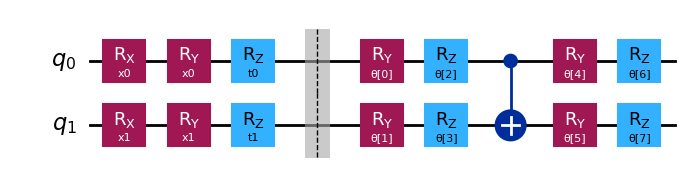

In [14]:
num_inputs = X_train.shape[1]
num_classes = len(np.unique(y_train))
feature_map = build_trainable_feature_map(num_inputs)
ansatz = TwoLocal(num_inputs, ['ry', 'rz'], 'cx', 'linear', reps=1)

observable = make_nclass_observables_unique(num_inputs, num_classes, seed=42)

q_model_s1 = QuantumNN(num_features = num_inputs).build(feature_map, ansatz, observable)
q_model_s1.plot('mpl', decompose_level=1)

In [15]:
%%time
q_model_s1.fit(X_train, y_train, epochs=50, lr=0.5, verbose=True, seed=42)

[Epoch 1] loss=1.15340, train_acc=0.3968, val_loss=1.05895, val_acc=0.5714
[Epoch 2] loss=1.04807, train_acc=0.6667, val_loss=0.99070, val_acc=0.7143
[Epoch 3] loss=0.96186, train_acc=0.7778, val_loss=0.94005, val_acc=0.7143
[Epoch 4] loss=0.90619, train_acc=0.8889, val_loss=0.89137, val_acc=0.7143
[Epoch 5] loss=0.87303, train_acc=0.8889, val_loss=0.85373, val_acc=0.7143
[Epoch 6] loss=0.85196, train_acc=0.9048, val_loss=0.82771, val_acc=1.0000
[Epoch 7] loss=0.83701, train_acc=0.9206, val_loss=0.80949, val_acc=1.0000
[Epoch 8] loss=0.82651, train_acc=0.9206, val_loss=0.79667, val_acc=1.0000
[Epoch 9] loss=0.81902, train_acc=0.9206, val_loss=0.78757, val_acc=1.0000
[Epoch 10] loss=0.81371, train_acc=0.9206, val_loss=0.78104, val_acc=1.0000
[Epoch 11] loss=0.80946, train_acc=0.9365, val_loss=0.77626, val_acc=1.0000
[Epoch 12] loss=0.80615, train_acc=0.9524, val_loss=0.77269, val_acc=1.0000
[Epoch 13] loss=0.80364, train_acc=0.9524, val_loss=0.76997, val_acc=1.0000
[Epoch 14] loss=0.801

QuantumNN(num_features=2, built=True, num_params=10)

### Quantum Scenario

In [16]:
X_train, y_train, _, _ = gen_ad_hoc()

#### CNN

In [17]:
c_model_s2 = classical_NN(num_features = X_train.shape[1],
                     num_classes = len(np.unique(y_train)))
c_model_s2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
c_model_s2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,817 (11.00 KB)

 Trainable params: 2,817 (11.00 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
%%time
_ = c_model_s2.fit(
    X_train, y_train,
    epochs=300,
    batch_size=10,
    validation_split=0.1,
    verbose=2
)


Epoch 1/300
7/7 - 2s - 307ms/step - accuracy: 0.4762 - loss: 0.7409 - val_accuracy: 0.2857 - val_loss: 0.7545
Epoch 2/300
7/7 - 0s - 15ms/step - accuracy: 0.4921 - loss: 0.7088 - val_accuracy: 0.1429 - val_loss: 0.7341
Epoch 3/300
7/7 - 0s - 15ms/step - accuracy: 0.5397 - loss: 0.6980 - val_accuracy: 0.0000e+00 - val_loss: 0.7580
Epoch 4/300
7/7 - 0s - 14ms/step - accuracy: 0.5556 - loss: 0.6929 - val_accuracy: 0.0000e+00 - val_loss: 0.7525
Epoch 5/300
7/7 - 0s - 15ms/step - accuracy: 0.5556 - loss: 0.6869 - val_accuracy: 0.0000e+00 - val_loss: 0.7814
Epoch 6/300
7/7 - 0s - 15ms/step - accuracy: 0.5556 - loss: 0.6820 - val_accuracy: 0.0000e+00 - val_loss: 0.7698
Epoch 7/300
7/7 - 0s - 15ms/step - accuracy: 0.5714 - loss: 0.6788 - val_accuracy: 0.2857 - val_loss: 0.7691
Epoch 8/300
7/7 - 0s - 14ms/step - accuracy: 0.6667 - loss: 0.6773 - val_accuracy: 0.2857 - val_loss: 0.7484
Epoch 9/300
7/7 - 0s - 15ms/step - accuracy: 0.6508 - loss: 0.6746 - val_accuracy: 0.2857 - val_loss: 0.7776
Ep

#### QNN

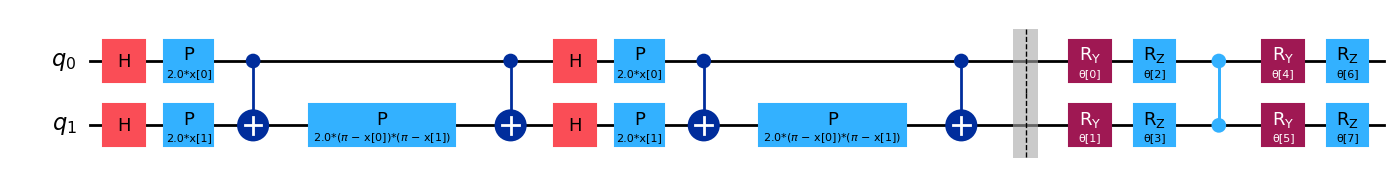

In [19]:
num_inputs = X_train.shape[1]
num_classes = len(np.unique(y_train))
feature_map = ZZFeatureMap(num_inputs, parameter_prefix='x')
ansatz = TwoLocal(num_inputs, ['ry', 'rz'], 'cz', 'linear', reps=1)

observable = make_nclass_observables_unique(num_inputs, num_classes, seed=42)

q_model_s2 = QuantumNN(num_features = num_inputs).build(feature_map, ansatz, observable)
q_model_s2.plot('mpl', decompose_level=1)

In [20]:
%%time
q_model_s2.fit(X_train, y_train, epochs=50, lr=0.8, verbose=True, val_split=0.1, seed=42)

[Epoch 1] loss=0.65454, train_acc=0.6032, val_loss=0.53088, val_acc=0.8571
[Epoch 2] loss=0.62651, train_acc=0.6825, val_loss=0.50551, val_acc=0.8571
[Epoch 3] loss=0.60269, train_acc=0.6984, val_loss=0.48572, val_acc=0.8571
[Epoch 4] loss=0.58274, train_acc=0.7460, val_loss=0.47031, val_acc=0.8571
[Epoch 5] loss=0.56615, train_acc=0.7778, val_loss=0.45826, val_acc=0.8571
[Epoch 6] loss=0.55237, train_acc=0.7937, val_loss=0.44879, val_acc=0.8571
[Epoch 7] loss=0.54091, train_acc=0.8095, val_loss=0.44131, val_acc=1.0000
[Epoch 8] loss=0.53136, train_acc=0.8889, val_loss=0.43542, val_acc=1.0000
[Epoch 9] loss=0.52339, train_acc=0.9048, val_loss=0.43081, val_acc=1.0000
[Epoch 10] loss=0.51673, train_acc=0.9206, val_loss=0.42724, val_acc=1.0000
[Epoch 11] loss=0.51116, train_acc=0.9524, val_loss=0.42450, val_acc=1.0000
[Epoch 12] loss=0.50648, train_acc=0.9524, val_loss=0.42244, val_acc=1.0000
[Epoch 13] loss=0.50255, train_acc=0.9524, val_loss=0.42090, val_acc=1.0000
[Epoch 14] loss=0.499

QuantumNN(num_features=2, built=True, num_params=8)

### Qiskit Example Scenario

In [21]:
X_train, _, y_train, _ = generate_dataset()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

#### CNN

In [22]:
y_train_ = (np.array(y_train)+1)/2
c_model_s3 = classical_NN(num_features = X_train.shape[1],
                     num_classes = len(np.unique(y_train_)))

c_model_s3.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])
c_model_s3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
%%time
_ = c_model_s3.fit(X_train, y_train_,
               epochs=30,
               batch_size=10,
               validation_split=0.1,
               verbose=2)

Epoch 1/30
7/7 - 2s - 215ms/step - accuracy: 0.5079 - loss: 0.6964 - val_accuracy: 0.5714 - val_loss: 0.6681
Epoch 2/30
7/7 - 0s - 14ms/step - accuracy: 0.6984 - loss: 0.6417 - val_accuracy: 0.7143 - val_loss: 0.6332
Epoch 3/30
7/7 - 0s - 14ms/step - accuracy: 0.7460 - loss: 0.6067 - val_accuracy: 0.7143 - val_loss: 0.6017
Epoch 4/30
7/7 - 0s - 14ms/step - accuracy: 0.7460 - loss: 0.5751 - val_accuracy: 0.7143 - val_loss: 0.5670
Epoch 5/30
7/7 - 0s - 14ms/step - accuracy: 0.7460 - loss: 0.5409 - val_accuracy: 0.7143 - val_loss: 0.5377
Epoch 6/30
7/7 - 0s - 14ms/step - accuracy: 0.8095 - loss: 0.5106 - val_accuracy: 0.7143 - val_loss: 0.5126
Epoch 7/30
7/7 - 0s - 14ms/step - accuracy: 0.8095 - loss: 0.4802 - val_accuracy: 0.8571 - val_loss: 0.4861
Epoch 8/30
7/7 - 0s - 15ms/step - accuracy: 0.8730 - loss: 0.4487 - val_accuracy: 0.8571 - val_loss: 0.4577
Epoch 9/30
7/7 - 0s - 14ms/step - accuracy: 0.9365 - loss: 0.4177 - val_accuracy: 0.8571 - val_loss: 0.4290
Epoch 10/30
7/7 - 0s - 14ms

#### QNN

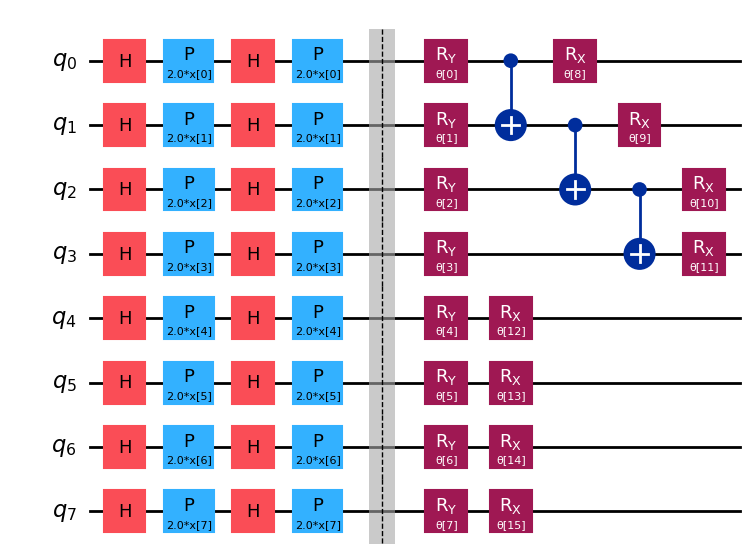

In [24]:
num_inputs = X_train.shape[1]
num_classes = len(np.unique(y_train))
feature_map = z_feature_map(num_inputs, parameter_prefix='x')

qnn_circuit = QuantumCircuit(size)
params = ParameterVector("θ", length=2 * size)
for i in range(size):
    qnn_circuit.ry(params[i], i)

qnn_cnot_list = [[0, 1], [1, 2], [2, 3]]

for i in range(len(qnn_cnot_list)):
    qnn_circuit.cx(qnn_cnot_list[i][0], qnn_cnot_list[i][1])

for i in range(size):
    qnn_circuit.rx(params[size + i], i)

ansatz = qnn_circuit

observable = make_nclass_observables_unique(num_inputs, num_classes, seed=42)

q_model_s3 = QuantumNN(num_features = num_inputs).build(feature_map, ansatz, observable)
q_model_s3.plot('mpl', decompose_level=0)

In [25]:
%%time
q_model_s3.fit(X_train, y_train, epochs=50, lr=0.95, verbose=True, seed=42, val_split=0.1)

[Epoch 1] loss=0.69013, train_acc=0.2857, val_loss=0.69216, val_acc=0.4286
[Epoch 2] loss=0.69007, train_acc=0.2857, val_loss=0.69213, val_acc=0.4286
[Epoch 3] loss=0.69001, train_acc=0.2857, val_loss=0.69211, val_acc=0.4286
[Epoch 4] loss=0.68995, train_acc=0.2857, val_loss=0.69209, val_acc=0.4286
[Epoch 5] loss=0.68989, train_acc=0.2857, val_loss=0.69206, val_acc=0.4286
[Epoch 6] loss=0.68983, train_acc=0.3016, val_loss=0.69204, val_acc=0.4286
[Epoch 7] loss=0.68976, train_acc=0.3016, val_loss=0.69201, val_acc=0.4286
[Epoch 8] loss=0.68970, train_acc=0.3016, val_loss=0.69199, val_acc=0.4286
[Epoch 9] loss=0.68964, train_acc=0.3016, val_loss=0.69197, val_acc=0.4286
[Epoch 10] loss=0.68958, train_acc=0.3016, val_loss=0.69194, val_acc=0.4286
[Epoch 11] loss=0.68951, train_acc=0.3016, val_loss=0.69192, val_acc=0.4286
[Epoch 12] loss=0.68945, train_acc=0.3016, val_loss=0.69189, val_acc=0.4286
[Epoch 13] loss=0.68939, train_acc=0.3016, val_loss=0.69187, val_acc=0.4286
[Epoch 14] loss=0.689

QuantumNN(num_features=8, built=True, num_params=16)

## Checking results

In [26]:
def present_results_classic(model, X_test, y_test):
  y_pred = model.predict(X_test)
  if y_pred.shape[1] > 1:
    y_pred = np.argmax(y_pred, axis=1)
  else:
    y_pred = np.round(y_pred).flatten()
  print(classification_report(y_test, y_pred))

def present_results_quantum(model, X_test, y_test):
  y_pred = model.predict(X_test)
  print(classification_report(y_test, y_pred))

def plot_decision_region(X, y_test, pred_fun, vmin=-2, vmax=2):
    unique_classes = np.unique(y_test)
    min_c = np.min(unique_classes)
    max_c = np.max(unique_classes)
    normalize_label = lambda x: 2 * (x - min_c) / (max_c - min_c) - 1
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 20)
    y_vals = np.linspace(min_y, max_y, 20)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = normalize_label(pred_fun(XX[i, j], YY[i, j]))
    pl.contourf(XX, YY, ZZ, 30, cmap = pl.cm.coolwarm, vmin=vmin, vmax=vmax)
    pl.xlabel("x")
    pl.ylabel("y")

def plot_data(X, y, title = "Data"):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  color=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title(title)

### Classical scenario

In [27]:
X_train, X_test, y_train, y_test = gen_toy()
scaler = StandardScaler()
X_test = scaler.fit(X_train).transform(X_test)

#### CNN

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        14

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

CPU times: user 26.7 s, sys: 4.01 s, total: 30.7 s
Wall time: 29.2 s


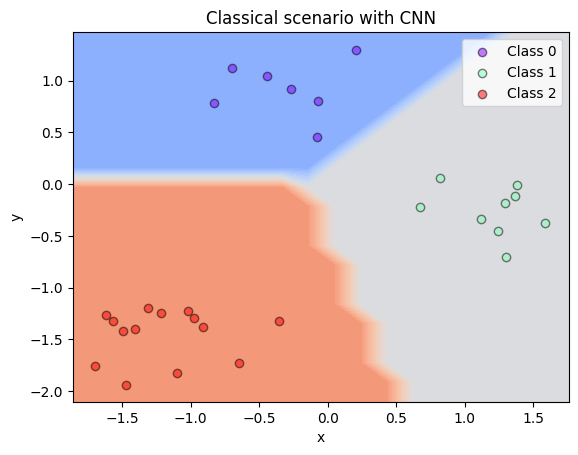

In [28]:
%%time
present_results_classic(c_model_s1, X_test, y_test)
plot_decision_region(X_test, y_test,
                     lambda x, y: np.argmax(
                                                c_model_s1.predict(np.array([[x, y]]), verbose=0)
                                            )
                     )
plot_data(X_test, y_test, title='Classical scenario with CNN')

#### QNN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        14

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

CPU times: user 2.72 s, sys: 899 ms, total: 3.61 s
Wall time: 3.91 s


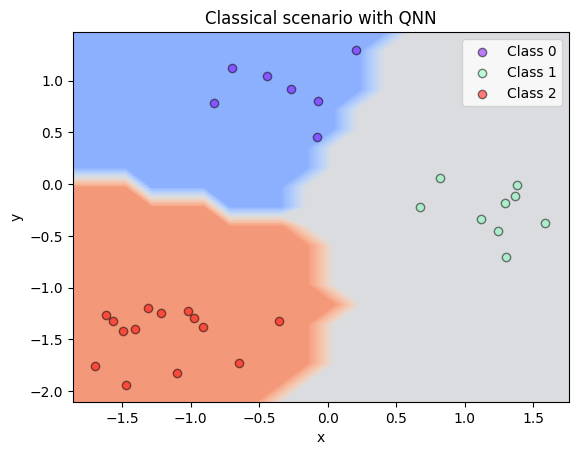

In [29]:
%%time
present_results_quantum(q_model_s1, X_test, y_test)
plot_decision_region(X_test, y_test,
                     lambda x, y: q_model_s1.predict(np.array([[x, y]])).item()
                     )
plot_data(X_test, y_test, title='Classical scenario with QNN')

In [30]:
q_model_s1.predict(np.array([[0, 0]]))

array([1])

### Quantum scenario

In [31]:
a, b, X_test, y_test = gen_ad_hoc()

#### CNN

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
              precision    recall  f1-score   support

           0       0.62      0.67      0.65        15
           1       0.64      0.60      0.62        15

    accuracy                           0.63        30
   macro avg       0.63      0.63      0.63        30
weighted avg       0.63      0.63      0.63        30

CPU times: user 26.2 s, sys: 3.69 s, total: 29.8 s
Wall time: 28.4 s


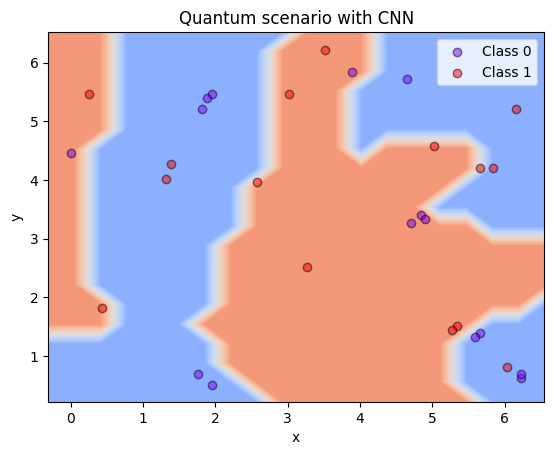

In [32]:
%%time
present_results_classic(c_model_s2, X_test, y_test)
plot_decision_region(X_test, y_test,
                     lambda x, y: np.round(
                                                c_model_s2.predict(np.array([[x, y]]), verbose=0)
                                            ).item()
                     )
plot_data(X_test, y_test, title='Quantum scenario with CNN')

#### QNN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        15

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

CPU times: user 1.28 s, sys: 341 ms, total: 1.62 s
Wall time: 1.79 s


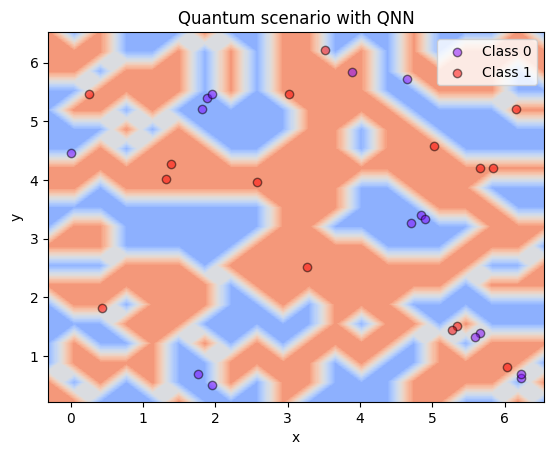

In [33]:
%%time
present_results_quantum(q_model_s2, X_test, y_test)
plot_decision_region(X_test, y_test,
                     lambda x, y: q_model_s2.predict(np.array([[x, y]])).item()
                     )
plot_data(X_test, y_test, title='Quantum scenario with QNN')

### Qiskit Example Scenario

In [34]:
class Model:
  def __init__(self, model):
    self.model = model
  def predict(self, X):
    return 2*self.model.predict(X)-1

X_train, X_test, y_train, y_test = generate_dataset()
scaler = StandardScaler()
X_test = scaler.fit(X_train).transform(X_test)

#### CNN

In [35]:
%%time
present_results_classic(Model(c_model_s3), X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        19

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

CPU times: user 113 ms, sys: 23.1 ms, total: 136 ms
Wall time: 128 ms


#### QNN

In [36]:
%%time
present_results_quantum(q_model_s3, X_test, y_test)

              precision    recall  f1-score   support

          -1       0.38      0.55      0.44        11
           1       0.64      0.47      0.55        19

    accuracy                           0.50        30
   macro avg       0.51      0.51      0.49        30
weighted avg       0.54      0.50      0.51        30

CPU times: user 143 ms, sys: 39.3 ms, total: 182 ms
Wall time: 196 ms


## Conclusions

### From the classical NNs

1. The classical neural network often converged to predicting only one class, showing that it struggled to learn a meaningful boundary on the ad-hoc dataset.

2. Increasing the model size or training for more epochs did not significantly improve performance, suggesting the difficulty lies in the dataset rather than the architecture.

3. The decision regions generated by the classical model were unstable and inconsistent, indicating poor generalization on highly mixed data.

4. The classical approach showed strong sensitivity to how the data was distributed, making its performance unreliable for the quantum specific task.

### From Quantum NNs

1.  Quantum algorithms demonstrate a unique aptitude for classifying data with inherent quantum structures, such as the specially designed ad-hoc dataset.

2. The performance of a Quantum Neural Network is critically dependent on the careful design of its feature map and the observables used for measurement.

3. Current quantum models face significant performance bottlenecks in training time due to the classical simulation of quantum circuits.

4. Parameterized quantum circuits show adaptability by learning optimal data representations through a hybrid quantum-classical optimization process.

### From Panorama and differences

1. The key difference lies in data representation: classical NNs use explicit hierarchical layers, while QNNs leverage quantum state space for implicit, high-dimensional feature mapping.

2. Future prospects for quantum machine learning are most promising in a hybrid regime, where quantum processors handle specific, complex sub-tasks within a classical computing framework.

3. While classical NNs benefit from mature hardware and software, quantum models represent a nascent technology with a long-term potential for exponential speedup on suitable problems.

4. The "black box" nature of quantum circuit learning presents a greater interpretability challenge compared to the more established analysis tools for classical neural networks.

## Qiskit Elements used in the Notebook



*   [`ad_hoc_data`](https://qiskit.org/ecosystem/machine-learning/stubs/qiskit_machine_learning.datasets.ad_hoc_data.html)
*   [`ZZFeatureMap`](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.circuit.library.ZZFeatureMap)
*   [`TwoLocal`](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.circuit.library.TwoLocal)
*   [`Estimator`](https://quantum.cloud.ibm.com/docs/en/api/qiskit-ibm-runtime/estimator-v2)
*   [`SparsePauliOp`](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.quantum_info.SparsePauliOp)
*   [`Parameter`](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.circuit.Parameter)